# Introduction

This challenge aims to create a solution to identify frauds.

Among the main steps of the process are:

- exploratory analysis
- Correlation
- Feature creation
- Model creation
- Verification of the performance of models

The dataset can be found here:
https://drive.google.com/file/d/1zjK8zQK5zvhR_r2chWI5dCjeOwASlPfb/view?usp=sharing

Features:
- step - represents the total hours elapsed since the beginning of the simulation. This feature will vary between 1 and 744 (30 days);

- type - transaction type (deposit, withdrawal, debit, payment and transfer);

- amount - total that was transacted;

- nameOrig - customer who initiated the transaction

- oldbalanceOrg - balance of the original account before the transaction;

- newbalanceOrig - balance of the origin account after the transaction;

- nameDest - target client of the transaction;

- oldbalanceDest - balance of the destination account before the transaction;

- newbalanceDest - balance of the destination account after the transaction;

- isFraud - flag that defines whether the transaction is fraudulent or not. In this simulation the purpose of the fraud is to take over the user's account, empty it by transferring it to another account and then withdrawing the money.

- isFlaggedFraud - automatically flagged by the bank as fraud for trying to transfer more than 200,000 in a single transaction.

# Importing the dataset

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import asarray

from datetime import datetime as dt
from datetime import timedelta as td

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split 

# Feature importance
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing dataset from Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
# importing frauds dataset
df = pd.read_csv('/content/gdrive/My Drive/Curso TERA/Desafio Classificação - Fraude/fraud_detection_dataset.csv')

In [4]:
# verifying the dataset
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# basic informations
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            6362620 non-null  int64  
 1   type            6362620 non-null  object 
 2   amount          6362620 non-null  float64
 3   nameOrig        6362620 non-null  object 
 4   oldbalanceOrg   6362620 non-null  float64
 5   newbalanceOrig  6362620 non-null  float64
 6   nameDest        6362620 non-null  object 
 7   oldbalanceDest  6362620 non-null  float64
 8   newbalanceDest  6362620 non-null  float64
 9   isFraud         6362620 non-null  int64  
 10  isFlaggedFraud  6362620 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


There isn't any null value in the dataset

In [6]:
# initial statistics
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
# checking the size of the dataset
df.shape

(6362620, 11)

# EDA

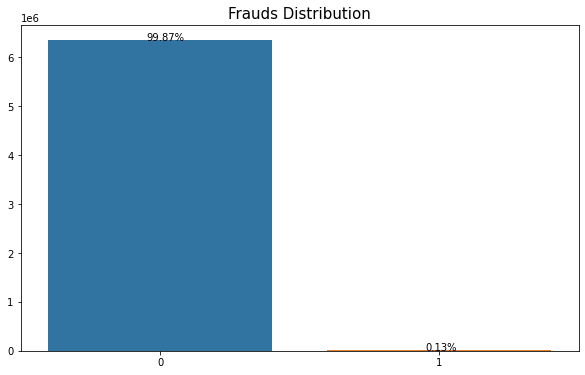

In [9]:
# frauds distribution
plt.figure(figsize = (10,6))

ax = sns.countplot(df.isFraud)
ax.set_title('Frauds Distribution', fontsize = 15)
ax.set_xlabel("")
ax.set_ylabel("")
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(df.isFraud)), (p.get_x()+ 0.35, p.get_height()+1000))

Note that 0.13% of transactions are fraudulent.

Percentage is low, but it can mean a very big loss if not detected

Now, let's see how the bank's fraud detection engine performs.

First, we analyzed the total fraud referral that was performed

In [11]:
# total indicated as frauds by the bank
print('Indicated by the bank: {} ({}%)'.format(df.isFlaggedFraud.sum(),round((df.isFlaggedFraud.sum()/df.isFraud.sum()*100),2)))
print('Real frauds:', df.isFraud.sum())

Indicated by the bank: 16 (0.19%)
Real frauds: 8213


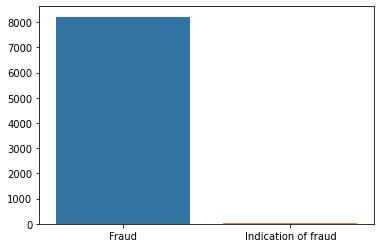

In [13]:
# comparing real frauds and those indicated by the bank
ax = sns.barplot(x = ['Fraud', 'Indication of fraud'],
                 y = [df.isFraud.sum(), df.isFlaggedFraud.sum()])

Only 0.19% of Indications of Fraud by the bank (transactions over 200,000) were actually frauds. This shows that the bank's system is very inefficient



## Distribution of frauds over time

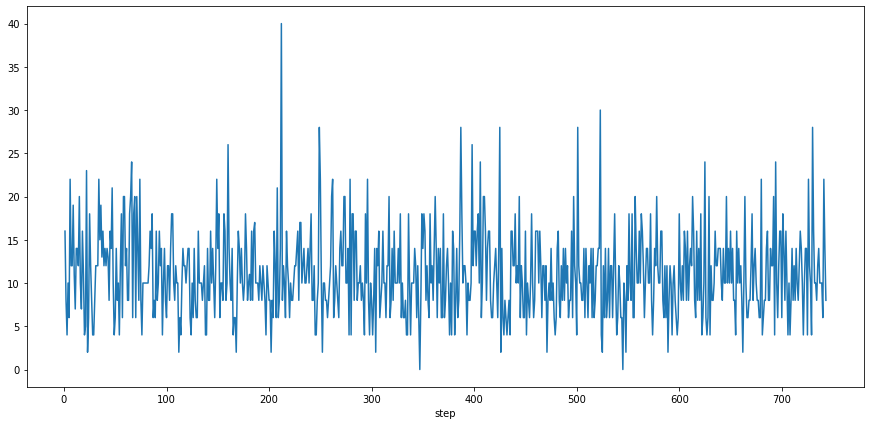

In [20]:
# checking frauds over time
plt.figure(figsize=(15,7))
df.groupby('step')['isFraud'].sum().plot()

In [15]:
df.groupby('step')['isFraud'].count()[:50]

step
1      2708
2      1014
3       552
4       565
5       665
6      1660
7      6837
8     21097
9     37628
10    35991
11    37241
12    36153
13    37515
14    41485
15    44609
16    42471
17    43361
18    49579
19    51352
20    40625
21    19152
22    12635
23     6144
24     3216
25     1598
26      440
27       41
28        4
29        4
30        8
31       12
32       12
33    23616
34    30904
35    29157
36    39774
37    34000
38    31453
39    23391
40    34270
41    36348
42    41304
43    45060
44    38523
45    18500
46    12445
47     8681
48     5693
49      764
50        6
Name: isFraud, dtype: int64

In [16]:
df.groupby('step')['isFraud'].sum()[:50]

step
1     16
2      8
3      4
4     10
5      6
6     22
7     12
8     12
9     19
10    11
11     7
12    14
13    14
14    12
15    20
16    10
17     7
18    16
19    11
20     4
21     5
22    23
23     2
24     6
25    18
26    12
27     8
28     4
29     4
30     8
31    12
32    12
33    12
34    22
35    15
36    19
37    13
38    16
39    12
40    14
41    12
42    14
43    13
44     8
45    16
46    14
47    21
48    10
49     4
50     6
Name: isFraud, dtype: int64

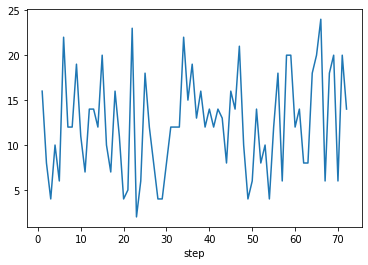

In [17]:
df.groupby('step')['isFraud'].sum()[:72].plot()

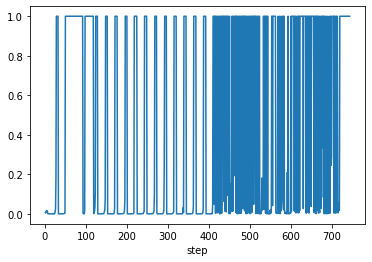

In [18]:
(df.groupby('step')['isFraud'].sum()/df.groupby('step')['isFraud'].count()).plot()

In [19]:
(df.groupby('step')['isFraud'].sum()/df.groupby('step')['isFraud'].count())[:50]

step
1     0.005908
2     0.007890
3     0.007246
4     0.017699
5     0.009023
6     0.013253
7     0.001755
8     0.000569
9     0.000505
10    0.000306
11    0.000188
12    0.000387
13    0.000373
14    0.000289
15    0.000448
16    0.000235
17    0.000161
18    0.000323
19    0.000214
20    0.000098
21    0.000261
22    0.001820
23    0.000326
24    0.001866
25    0.011264
26    0.027273
27    0.195122
28    1.000000
29    1.000000
30    1.000000
31    1.000000
32    1.000000
33    0.000508
34    0.000712
35    0.000514
36    0.000478
37    0.000382
38    0.000509
39    0.000513
40    0.000409
41    0.000330
42    0.000339
43    0.000289
44    0.000208
45    0.000865
46    0.001125
47    0.002419
48    0.001757
49    0.005236
50    1.000000
Name: isFraud, dtype: float64

There seems to be a fluctuation of frauds during the hours..

This could be an indication for us to create a new feature that indicates the time of day.

## Distribution of amount of operations

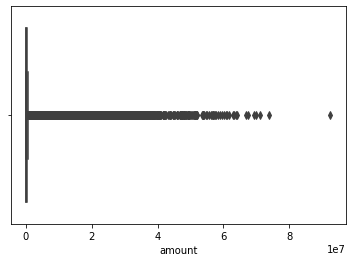

In [21]:
# Plot the transaction qty
# divided by fraud/non-fraud

sns.boxplot(df.amount)

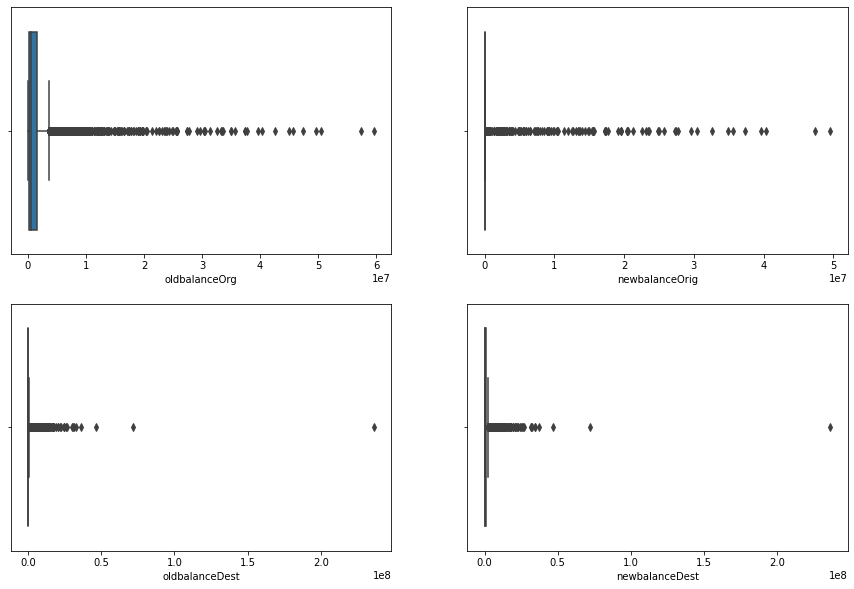

In [22]:
# checking distribution of source and destination accounts
# when FRAUD
features_contas = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

fig = plt.figure(figsize=(15, 10))

for column in features_contas:
  ax = fig.add_subplot(2, 2, features_contas.index(column)+1)
  sns.boxplot(df[df.isFraud==1][column])

Transaction amounts, as well as balances in the source and destination accounts, have distribution curves skewed to the right.

All have outliers.

## Types os transactions

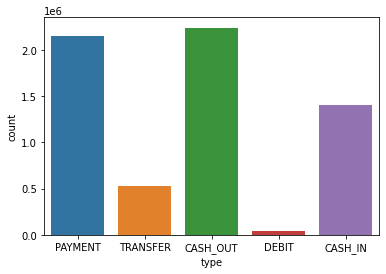

In [23]:
# types os payments distribution
sns.countplot(df['type'])

In [24]:
df[df['isFraud']==1]['type'].value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

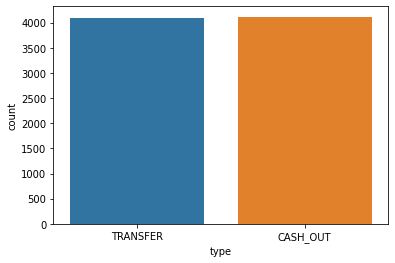

In [25]:
# frauds types os payment distribution
sns.countplot(df[df['isFraud']==1]['type'])

There were only frauds in transfers and cash out

## Names Evaluation

In [26]:
# quantity of each name in the origin list
df.nameOrig.value_counts()

C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: nameOrig, Length: 6353307, dtype: int64

In [27]:
# quantity of each destiny list name
df.nameDest.value_counts()

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: nameDest, Length: 2722362, dtype: int64

There are much larger amounts for the same target name than source

We can analyze the target names a little deeper

### How many transactions were there for recipients of fraudulent transactions?

In [28]:
df[df.isFraud==1]['nameDest'].value_counts()

C1193568854    2
C104038589     2
C200064275     2
C1497532505    2
C1601170327    2
              ..
C317811789     1
C24324787      1
C1053414206    1
C2013070624    1
C873221189     1
Name: nameDest, Length: 8169, dtype: int64

For the same recipient, there were few repetitions of names when the transaction is fraudulent.

But could there have been normal transactions for these recipients before the fraud took place?

Let's count the total transactions for these recipients

In [29]:
df_Quant_Trans_Dest = pd.DataFrame({'names_Dest': df.nameDest.value_counts().index.tolist(),
                                    'quantTrans': df.nameDest.value_counts()}).reset_index()

In [30]:
name_dest_fraudes = df[df.isFraud==1]['nameDest'].value_counts().index.tolist()

In [31]:
df_Quant_Trans_Dest_Frauds = df_Quant_Trans_Dest[df_Quant_Trans_Dest['names_Dest'].isin(name_dest_fraudes)].drop('index', axis=1)

In [32]:
df_Quant_Trans_Dest_Frauds.reset_index(inplace=True)

In [33]:
df_Quant_Trans_Dest_Frauds.drop('index', axis=1, inplace=True)

In [34]:
df_Quant_Trans_Dest_Frauds

,names_Dest,quantTrans
0,C716083600,89
1,C667346055,86
2,C932583850,82
3,C766681183,80
4,C803116137,77
...,...,...
8164,C2100877994,1
8165,C825722694,1
8166,C195893407,1
8167,C2033959349,1


Some of the recipients of fraudulent transactions made many transactions in the period. Of these, only 1 or 2 were fraudulent.

Let's see the distribution of the amount of transactions of recipients who had at least one fraudulent transaction.

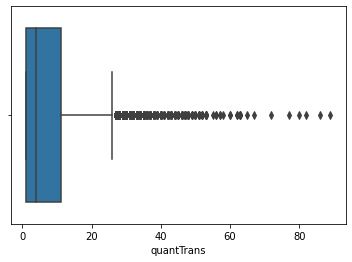

In [35]:
# boxplot of recipient transactions
# that had at least one fraudulent

sns.boxplot(df_Quant_Trans_Dest_Frauds['quantTrans'])

In [36]:
print('50% of data are between {} e {}'.format(df_Quant_Trans_Dest_Frauds['quantTrans'].quantile(.25),
                                                 df_Quant_Trans_Dest_Frauds['quantTrans'].quantile(.75)))

50% of data are between 1.0 e 11.0


Is this distribution different from the other recipients? (those who have not been in any fraudulent transactions)

In [37]:
# recipients who have not been in fraudulent transactions
df_Quant_Trans_Dest_NFrauds = df_Quant_Trans_Dest[~df_Quant_Trans_Dest['names_Dest'].isin(name_dest_fraudes)].drop('index', axis=1)

In [38]:
df_Quant_Trans_Dest_NFrauds.reset_index(inplace=True)

In [39]:
df_Quant_Trans_Dest_NFrauds.drop('index', axis=1, inplace=True)

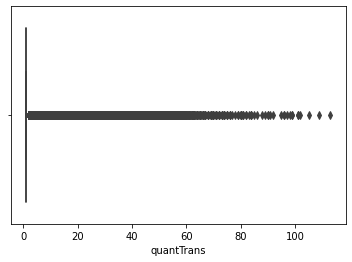

In [40]:
# boxplot of recipient transactions
# who have NOT been in any fraudulent transactions
sns.boxplot(df_Quant_Trans_Dest_NFrauds['quantTrans'])

In [41]:
print('50% of data are between {} e {}'.format(df_Quant_Trans_Dest_NFrauds['quantTrans'].quantile(.25),
                                                 df_Quant_Trans_Dest_NFrauds['quantTrans'].quantile(.75)))

50% of data are between 1.0 e 1.0


Among recipients who were in fraudulent transactions, and those who were not, there was a difference between the distributions of transaction quantities.

This can mean that creating a feature with the amount of transactions can be advantageous

### How many transactions were there for the Fraudulent Transaction Origin names?

In [42]:
# Creating a DF for source names in fraudulent transactions
df_Quant_Trans_Orig = pd.DataFrame({'names_Orig': df.nameOrig.value_counts().index.tolist(),
                                    'quantTrans': df.nameOrig.value_counts()}).reset_index()

In [43]:
# list with names of origin who have been in fraudulent operations
name_orig_fraudes = df[df.isFraud==1]['nameOrig'].value_counts().index.tolist()

In [44]:
df_Quant_Trans_Orig_Frauds = df_Quant_Trans_Orig[df_Quant_Trans_Orig['names_Orig'].isin(name_orig_fraudes)].drop('index', axis=1)

In [45]:
df_Quant_Trans_Orig_Frauds.reset_index(inplace=True)

In [46]:
df_Quant_Trans_Orig_Frauds.drop('index', axis = 1, inplace=True)

In [47]:
df_Quant_Trans_Orig_Frauds

,names_Orig,quantTrans
0,C357911107,2
1,C1882162040,2
2,C171834973,2
3,C1885333477,2
4,C803411135,2
...,...,...
8208,C1234321469,1
8209,C1246119241,1
8210,C949325212,1
8211,C1015989725,1


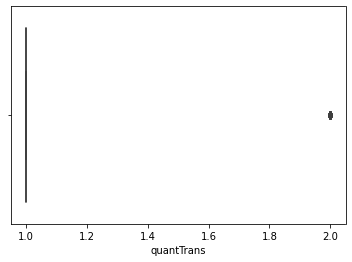

In [48]:
# boxplot of origin name transactions
# that had at least one fraudulent

sns.boxplot(df_Quant_Trans_Orig_Frauds['quantTrans'])

Now, for those origin names who haven't been in any fraudulent transactions

In [49]:
# origin names that have not been in fraudulent transactions
df_Quant_Trans_Orig_NFrauds = df_Quant_Trans_Orig[~df_Quant_Trans_Orig['names_Orig'].isin(name_orig_fraudes)].drop('index', axis=1)

In [50]:
df_Quant_Trans_Orig_NFrauds.reset_index(inplace=True)

In [51]:
df_Quant_Trans_Orig_NFrauds.drop('index', axis=1, inplace=True)

In [52]:
df_Quant_Trans_Orig_NFrauds

,names_Orig,quantTrans
0,C1902386530,3
1,C363736674,3
2,C545315117,3
3,C724452879,3
4,C1784010646,3
...,...,...
6345089,C740782868,1
6345090,C98968405,1
6345091,C720209255,1
6345092,C1567523029,1


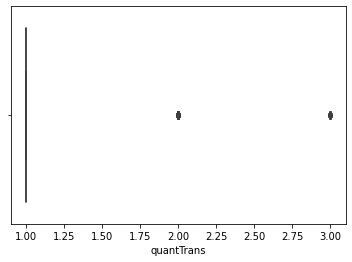

In [53]:
sns.boxplot(df_Quant_Trans_Orig_NFrauds['quantTrans'])

For origin names, it seems to make less sense to create a feature with qty of transactions. This is because for both fraudulent and non-fraudulent transactions, the distribution is similar

## Correlation

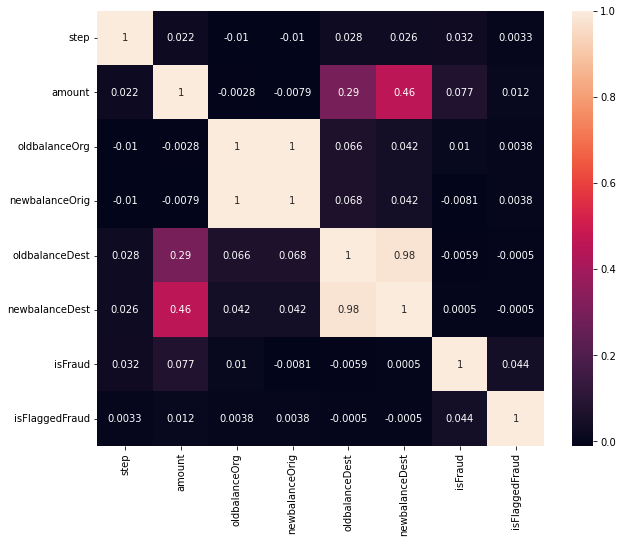

In [54]:
# plotting the correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(round(df.corr(),4),
            annot=True)

As it stands, numerical features do not have a strong linear correlation with fraud.

We'll create some features and run our models to see how they perform.

Also, there is a strong correlation between newbalanceDest and oldbalanceDest, as well as between newbalanceDest and amount

So, during modelingwe can consider to remove newbalanceDest feature

# Feature Engineering

From our EDA, we saw that there is an oscillation of frauds over time.

So first let's break this time down into the hours of the day, i.e. from 0 to 23.

## Hours Feature

In [55]:
# creating a copy of the dataset
df_copia = df.copy()

In [56]:
# creating a dataframe of dates
# to convert our step into hours

data_inicio = dt(2021, 1, 1, 0, 0, 0) # start date and time of our count
datas = [data_inicio] # list to store dates

# stores dates in a list
for i in range(1, 743):
    data_inicio += td(seconds=3600)
    datas.append(data_inicio)

df_datas = pd.DataFrame({'dates': datas})
df_datas['step'] = df_datas.index+1
df_datas['hour'] = df_datas['dates'].dt.hour

# Remove the datetime object column.
df_datas.drop(['dates'], inplace=True, axis=1)

In [57]:
df_datas

,step,hour
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4
...,...,...
738,739,18
739,740,19
740,741,20
741,742,21


In [58]:
# joining our initial dataset with that of dates, by step

df_com_horas = pd.merge(df_copia, df_datas, on=['step'], how='left')

In [59]:
df_com_horas

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,22
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,22
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,22
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,22


## Dest Names

In [60]:
# creating df with the number of operations of the recipients in the last month
df_copia_nomes_dest = pd.DataFrame({'nameDest': df_copia['nameDest'].value_counts().index,
                                    'quantTrans': df_copia['nameDest'].value_counts()})

In [79]:
# creating feature of number of operations per recipient
df_novas_features = pd.merge(df_com_horas, df_copia_nomes_dest, on=['nameDest'], how='left')

In [80]:
df_novas_features = df_novas_features[['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
                                       'nameDest', 'oldbalanceDest', 'newbalanceDest',
                                       'hour', 'quantTrans', 'isFlaggedFraud', 'isFraud']]

In [81]:
df_novas_features

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,hour,quantTrans,isFlaggedFraud,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,1,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,1,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,0,44,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,0,41,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,22,2,0,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,22,1,0,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,22,3,0,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,22,1,0,1


## Checking Correlations of the New Hours Feature

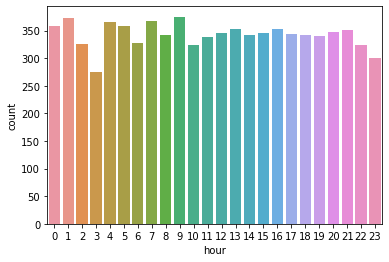

In [82]:
# time of day vs frauds
sns.countplot(df_novas_features[df_novas_features['isFraud']==1]['hour'])

In general, the amount of fraud during the day is constant. There is a more considerable decrease in hours 3 and 23.

Now, let's see the total operations during the day

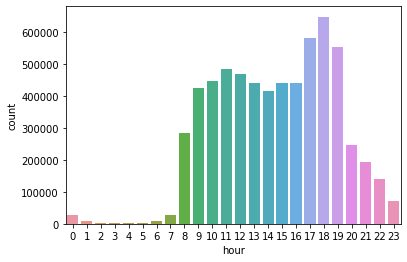

In [84]:
# hours of the day vs operations
sns.countplot(df_novas_features['hour'])

There are a lot more transactions during the 9th and 19th hours.

This indicates a much higher percentage of fraud at certain times of the day. let's analyze

In [85]:
df_horas_percentual_fraudes = pd.DataFrame({'hour': df_novas_features['hour'].unique(),
                                           'total':df_novas_features.groupby('hour')['isFraud'].count(),
                                           'frauds': df_novas_features.groupby('hour')['isFraud'].sum()})

In [86]:
df_horas_percentual_fraudes['frauds_ratio'] = round(df_horas_percentual_fraudes['frauds']/df_horas_percentual_fraudes['total'],2)

In [87]:
df_horas_percentual_fraudes.drop('hour', axis=1, inplace=True)

In [88]:
df_horas_percentual_fraudes

,total,frauds,frauds_ratio
hour,,,
0,27111,358,0.01
1,9018,372,0.04
2,2007,326,0.16
3,1241,274,0.22
4,1641,366,0.22
5,3420,358,0.10
6,8988,328,0.04
7,26915,368,0.01
8,283518,341,0.00


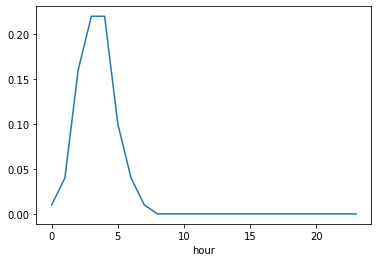

In [89]:
df_horas_percentual_fraudes.frauds_ratio.plot()

The first 8 hours are more likely to have frauds.

So, let's divide our hours into [0.7] -> [0] and [8.23] -> [1] and create a new feature!

In [90]:
df_horas_divididas = pd.DataFrame({'hour': [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
                                   'hour_class': [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]})

In [91]:
df_horas_divididas

,hour,hour_class
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
5,5,1
6,6,1
7,7,1
8,8,0
9,9,0


In [92]:
df_novas_features = pd.merge(df_novas_features,df_horas_divididas,on=['hour'], how='left')

In [93]:
df_novas_features = df_novas_features[['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'hour', 'hour_class','quantTrans',
       'isFlaggedFraud', 'isFraud']]

In [94]:
df_novas_features

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,hour,hour_class,quantTrans,isFlaggedFraud,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,1,1,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,1,1,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,0,1,44,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,0,1,41,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,22,0,2,0,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,22,0,1,0,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,22,0,3,0,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,22,0,1,0,1


We have just created two new features: quantTrans and hour_class.

So now, we can drop the other features related with them,as well as newbalanceDest, because of correlationswith other features

In [95]:
df_final_features = df_novas_features.drop(['step', 'nameOrig', 'nameDest', 'newbalanceDest', 'hour'], axis = 1)
df_final_features

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,hour_class,quantTrans,isFlaggedFraud,isFraud
0,PAYMENT,9839.64,170136.00,160296.36,0.00,1,1,0,0
1,PAYMENT,1864.28,21249.00,19384.72,0.00,1,1,0,0
2,TRANSFER,181.00,181.00,0.00,0.00,1,44,0,1
3,CASH_OUT,181.00,181.00,0.00,21182.00,1,41,0,1
4,PAYMENT,11668.14,41554.00,29885.86,0.00,1,1,0,0
...,...,...,...,...,...,...,...,...,...
6362615,CASH_OUT,339682.13,339682.13,0.00,0.00,0,2,0,1
6362616,TRANSFER,6311409.28,6311409.28,0.00,0.00,0,1,0,1
6362617,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,0,3,0,1
6362618,TRANSFER,850002.52,850002.52,0.00,0.00,0,1,0,1


# Preprocessing

In [96]:
# Dividing into training, testing and validation

def treino_teste_validacao(X, y): # X é o df de X e y é a series de y
  X = X.copy()

  # Primeiro, separando em treino e test_val (teste + validação)
  X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size = 0.30, random_state = 42)

  # Agora, separando test_val em test e valid
  X_test, X_valid, y_test, y_valid = train_test_split(X_test_val, y_test_val, test_size = 0.50, random_state = 42)

  return X_train, X_test, X_valid, y_train, y_test, y_valid

In [97]:
def preprocessing(X_train, X_valid, X_test, y_train):

  # Categorical preprocessing - encoding with OrdinalEncoder
  oe = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
  X_train[features_oe] = oe.fit_transform(X_train[features_oe])
  X_valid[features_oe] = oe.transform(X_valid[features_oe])
  X_test[features_oe] = oe.transform(X_test[features_oe])

  return X_train, X_valid, X_test

In [102]:
# deviding into training, testing and validation
# let's drop nameOrig and nameDest too
# nameOrig -> there are many different categories
# nameDest -> there are many different categories and we created a feature related to this one
X = df_final_features.drop(['isFraud'], axis=1)
y = df_final_features.isFraud

X_train, X_test, X_valid, y_train, y_test, y_valid = treino_teste_validacao(X=X, y=y)

In [103]:
print('X train:',X_train.shape)
print('y train:',y_train.shape)
print('X validation:',X_valid.shape)
print('y validation:',y_valid.shape)
print('X test:',X_test.shape)
print('y test:',y_test.shape)

X train: (4453834, 8)
y train: (4453834,)
X validation: (954393, 8)
y validation: (954393,)
X test: (954393, 8)
y test: (954393,)


In [104]:
# dataset preprocessing
features_oe = ['type']
X_train, X_valid, X_test = preprocessing(X_train.copy(), X_valid.copy(), X_test.copy(), y_train)

In [105]:
X_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4453834 entries, 2408104 to 1692743
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   type            4453834 non-null  float64
 1   amount          4453834 non-null  float64
 2   oldbalanceOrg   4453834 non-null  float64
 3   newbalanceOrig  4453834 non-null  float64
 4   oldbalanceDest  4453834 non-null  float64
 5   hour_class      4453834 non-null  int64  
 6   quantTrans      4453834 non-null  int64  
 7   isFlaggedFraud  4453834 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 305.8 MB


In [106]:
X_train

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,hour_class,quantTrans,isFlaggedFraud
2408104,0.0,26771.98,27521.00,54292.98,7175503.03,0,17,0
662430,1.0,344879.65,0.00,0.00,3731846.57,0,45,0
496595,4.0,1862607.84,0.00,0.00,3329828.01,0,31,0
5053741,3.0,37739.35,66684.93,28945.58,0.00,0,1,0
755621,1.0,376055.13,22501.00,0.00,182350.43,0,20,0
...,...,...,...,...,...,...,...,...
1570006,0.0,129715.85,5054252.83,5183968.68,246692.94,0,12,0
2234489,3.0,2459.70,0.00,0.00,0.00,0,1,0
4926484,1.0,10579.16,59279.00,48699.84,322754.16,0,4,0
4304572,1.0,73020.76,20289.00,0.00,256102.84,0,8,0


# Baseline model (unbalanced dataset)

Once our dataset is too big for our processing power, We will with only 1 models here: Random Forest

For the evaluation, I will use the metrics recall, precision, accuracy and f1

In [111]:
# I would've used this function if I had enough processing powerfor it
def cross_val_models(X_train, y_train, models):
  cross_val_rec = []
  cross_val_prec = []
  cross_val_accur = []
  cross_val_f1 = []

  for model in models:
    cross_val_rec.append(cross_val_score(model, X_train, y_train, cv=5, scoring = 'recall').mean())
    cross_val_prec.append(cross_val_score(model, X_train, y_train, cv=5, scoring = 'precision').mean())
    cross_val_accur.append(cross_val_score(model, X_train, y_train, cv=5, scoring = 'accuracy').mean())
    cross_val_f1.append(cross_val_score(model, X_train, y_train, cv=5, scoring = 'f1').mean())

  df_cross_val = pd.DataFrame({'Recall': cross_val_rec,
                                  'Precision': cross_val_prec,
                                  'Accuracy': cross_val_accur,
                                  'f1': cross_val_f1},
                                  index = ['Logistic Regression', 'Random Forest', 'XGBoost'])
  return df_cross_val

In [108]:
# importing the libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


In [109]:
# ML models
lr = LogisticRegression(random_state=42)
rfc = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

Running RandomForest and checking precision, recall and f1 metrics

In [110]:
rfc.fit(X_train, y_train)
y_pred_train_rfc_baseline = rfc.predict(X_valid)
print(classification_report(y_valid, y_pred_train_rfc_baseline))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    953185
           1       0.94      0.78      0.85      1208

    accuracy                           1.00    954393
   macro avg       0.97      0.89      0.92    954393
weighted avg       1.00      1.00      1.00    954393



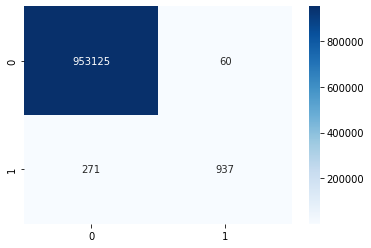

In [112]:
# creating the confusion matrix for the baseline
ax = sns.heatmap(confusion_matrix(y_valid, y_pred_train_rfc_baseline),
                 annot=True,
                 annot_kws={"fontsize":10},
                 fmt = 'd',
                 cmap = 'Blues')

# Modeling useing undersampling method

Let's use the undersampling method and run Random Forest, to check how the metrics are compared to the baseline.

As the dataset is big, theoretically we won't have big problems with this technique. Also, as the dataset will shrink considerably, we can test with other techniques, such as logistic regression and XGBoost.

For this, I will use the cross_val_models function

In [113]:
# importing lib undersampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [114]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print('Dataset after undersampling: %s' % Counter(y_train_rus))

Dataset after undersampling: Counter({0: 5778, 1: 5778})


Now, running the three models, for a balanced undersample training dataset, and using CrossVal


In [115]:
lr = LogisticRegression(random_state=42)
rfc = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

models = [lr, rfc, xgb]

cross_val_models(X_train_rus, y_train_rus, models=models)

,Recall,Precision,Accuracy,f1
Logistic Regression,0.985116,0.846858,0.902907,0.910540
Random Forest,0.996885,0.986835,0.991779,0.991828
XGBoost,0.996019,0.981615,0.988664,0.988754


In this case, there was a slight advantage for the Random Forest model.

So let's go with it

## Model RFC in validation

In [116]:
# rfc model with undersampled data in validation
rfc.fit(X_train_rus, y_train_rus)
y_pred_train_rfc_rus = rfc.predict(X_valid)
print(classification_report(y_valid, y_pred_train_rfc_rus))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    953185
           1       0.08      1.00      0.15      1208

    accuracy                           0.99    954393
   macro avg       0.54      0.99      0.57    954393
weighted avg       1.00      0.99      0.99    954393



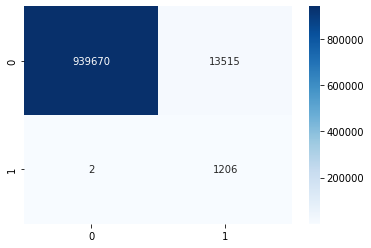

In [117]:
# creating confusion matrix for rfc model with undersampled
ax = sns.heatmap(confusion_matrix(y_valid, y_pred_train_rfc_rus),
                 annot=True,
                 annot_kws={"fontsize":10},
                 fmt = 'd',
                 cmap = 'Blues')

Since we lost a lot of data during undersampling, our evaluation metrics decreased so much.

This time it will not be possible to use the oversampling model, due to computational resources.

So, let's just continue with the unbalanced dataset, and adjusting the hyperparameters

# Unbalanced RFC Model - Hyperparameter Optimization

In [118]:
rfc = RandomForestClassifier(n_estimators=75,
                             max_depth=20,
                             max_features=0.25,
                             random_state=42)
rfc.fit(X_train, y_train)
y_pred_train_rfc_v1 = rfc.predict(X_valid)
print(classification_report(y_valid, y_pred_train_rfc_v1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    953185
           1       0.95      0.77      0.85      1208

    accuracy                           1.00    954393
   macro avg       0.97      0.88      0.92    954393
weighted avg       1.00      1.00      1.00    954393



In [119]:
rfc = RandomForestClassifier(n_estimators=50,
                             max_depth=10,
                             max_features=0.5,
                             random_state=42)
rfc.fit(X_train, y_train)
y_pred_train_rfc_v1 = rfc.predict(X_valid)
print(classification_report(y_valid, y_pred_train_rfc_v1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    953185
           1       0.96      0.64      0.77      1208

    accuracy                           1.00    954393
   macro avg       0.98      0.82      0.88    954393
weighted avg       1.00      1.00      1.00    954393



Could not run parameter optimization with GridSearchCV.

So, let's use the parameters that gave the best results:
 - n_estimators=75,
 - max_depth=20,
 - max_features=0.25

# Unbalanced model - TEST

In [120]:
rfc = RandomForestClassifier(n_estimators=75,
                             max_depth=20,
                             max_features=0.25,
                             random_state=42)
rfc.fit(X_train, y_train)

y_pred_train_rfc_teste = rfc.predict(X_test)
print(classification_report(y_test, y_pred_train_rfc_teste))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    953166
           1       0.96      0.75      0.84      1227

    accuracy                           1.00    954393
   macro avg       0.98      0.88      0.92    954393
weighted avg       1.00      1.00      1.00    954393



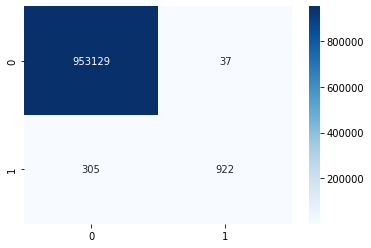

In [121]:
# creating confusion matrix for rfc in test dataset
ax = sns.heatmap(confusion_matrix(y_test, y_pred_train_rfc_teste),
                 annot=True,
                 annot_kws={"fontsize":10},
                 fmt = 'd',
                 cmap = 'Blues')

## ROC AUC - TEST

Random Forest Classifier TESTE score: 99.96
------------------------------------------------------------------------------------------


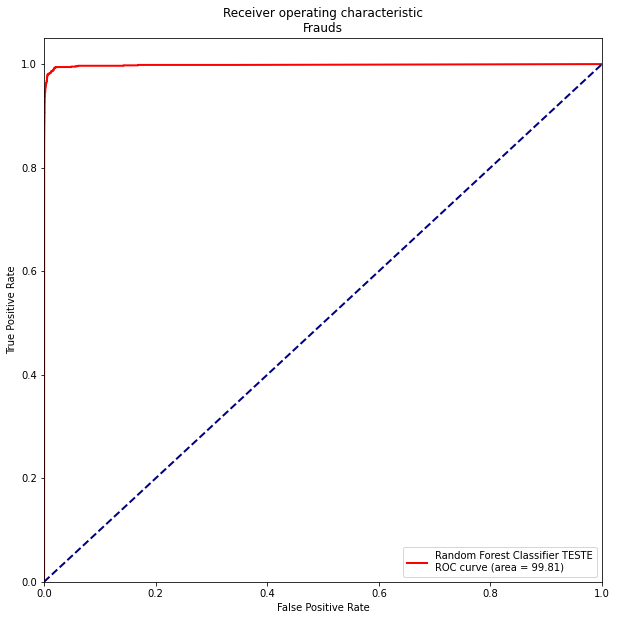

In [122]:
y_proba_teste_rfc = rfc.predict_proba(X_test)
y_proba_teste_rfc = y_proba_teste_rfc[:, 1]

print('Random Forest Classifier TESTE score:',
      round(rfc.score(X_test, y_test)*100,2))
print('-'*90)

roc_auc_rfc = roc_auc_score(y_test, y_proba_teste_rfc)

fpr_rfc, tpr_rfc, thresold_rfc = roc_curve(y_test, y_proba_teste_rfc)


plt.figure(figsize = (10,10))

plt.plot(fpr_rfc, tpr_rfc, color='Red',
        lw=2, label='Random Forest Classifier TESTE\nROC curve (area = %0.2f)' % round(roc_auc_score(y_test, y_proba_teste_rfc)*100,2))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic\nFrauds')
plt.legend(loc="lower right")
plt.show()